## XGBoost applied on FAANG stocks

In [5]:
import warnings
warnings.simplefilter('ignore')

import xgboost

from xgboost import XGBClassifier

#classification report and confusion matris
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#yahoo finance data
from pandas_datareader import data

import matplotlib.pyplot as plt
import seaborn as sn

import pandas as pd
import numpy as np

In [27]:
stock_list = ['AMZN' , 'AAPL' , 'AMZN' , 'NFLX' , 'GOOG']
stock_list = ['GC=F' , 'CL=F' , 'DX=F' , 'HON' , 'NEM']

start_date = '2004-1-1'
end_date = '2021-4-1'


In [28]:
stock_data_dictionary = {}

for stock_name in stock_list:

    df = data.get_data_yahoo(stock_name, start_date, end_date)
    
    #daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()
    
    #predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        predictor_list.append('std_'+str(r))
        
    #targe variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)
    
    df = df.dropna()
    
    stock_data_dictionary.update({stock_name: df})

In [29]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,daily_pct_change,pct_change_10,std_10,pct_change_15,...,pct_change_40,std_40,pct_change_45,std_45,pct_change_50,std_50,pct_change_55,std_55,return_next_day,actual_signal
Date,,,,,,,,,,,,,,,,,,,,,
2004-03-23,45.029999,44.180000,44.349998,44.680000,5002200.0,34.797848,0.002018,0.029027,0.015432,0.057474,...,0.075932,0.019145,0.045474,0.018891,-0.073009,0.020453,-0.072417,0.020416,-0.022157,-1
2004-03-24,44.389999,43.660000,44.299999,43.689999,4514800.0,34.026829,-0.022157,0.032646,0.014711,0.039813,...,0.035815,0.019332,0.008229,0.019075,-0.072130,0.020435,-0.117396,0.020332,0.034791,1
2004-03-25,45.250000,43.509998,43.599998,45.209999,4906500.0,35.210640,0.034791,0.057515,0.017749,0.062956,...,0.089190,0.019789,0.036845,0.019745,-0.017340,0.020884,-0.064313,0.020805,0.020791,1
2004-03-26,46.529999,45.750000,45.970001,46.150002,7192300.0,35.942711,0.020791,0.079709,0.018139,0.050852,...,0.124843,0.019803,0.084910,0.019489,0.044267,0.020255,-0.014857,0.020663,-0.002166,-1
2004-03-29,46.380001,45.200001,45.820000,46.049999,4719100.0,35.864849,-0.002166,0.093940,0.016498,0.060515,...,0.109051,0.019745,0.095593,0.019370,0.088238,0.019093,-0.026719,0.020619,0.014332,1


{'GC=F':                    High          Low         Open        Close   Volume  \
 Date                                                                      
 2004-03-24   417.200012   417.200012   417.200012   417.200012      2.0   
 2004-03-25   417.000000   416.000000   416.000000   416.700012      8.0   
 2004-03-26   422.000000   422.000000   422.000000   422.100006      8.0   
 2004-03-29   422.100006   422.100006   422.100006   417.100006  64296.0   
 2004-03-30   424.399994   416.500000   416.500000   421.700012  36663.0   
 ...                 ...          ...          ...          ...      ...   
 2021-02-26  1768.199951  1718.800049  1768.099976  1728.099976   1593.0   
 2021-03-01  1747.000000  1720.300049  1737.099976  1722.500000    407.0   
 2021-03-02  1733.099976  1708.699951  1709.400024  1733.099976    867.0   
 2021-03-03  1732.400024  1703.500000  1730.000000  1715.300049    501.0   
 2021-03-04  1717.400024  1700.199951  1706.500000  1700.199951    501.0   
 
  

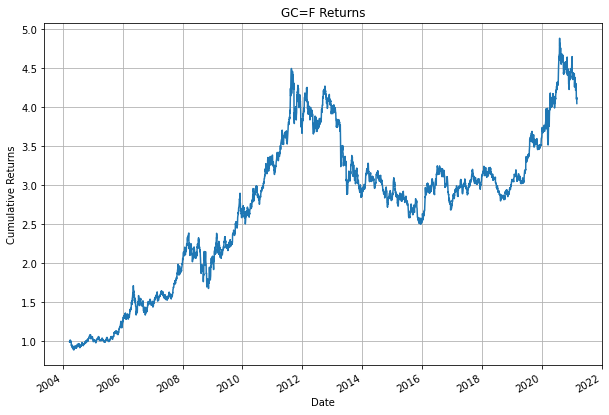

In [31]:
plt.figure(figsize=(10, 7))
# Access the dataframe of GOOG from the dictionary
# and then compute and plot the returns

(stock_data_dictionary[stock_list[0]].daily_pct_change+1).cumprod().plot()
    
# Set the title and axis lables and plot grid
plt.title(stock_list[0] + ' Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [10]:
#Training data and test data

In [32]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
    
for stock_name in stock_list:
        
    # Get predictor variables
    X = stock_data_dictionary[stock_name][predictor_list]
    
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal
    
    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

In [12]:
#Initialising the XGBoost model

In [33]:
model = XGBClassifier(max_depth =3, n_estimators=500, learning_rate=0.05, objective='reg:squarederror')

model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='reg:squarederror', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [34]:
#Cross validation

kfold = KFold (n_splits=5, random_state=7)

results = cross_val_score(model,X_train, y_train, cv=kfold)
mresults = results.mean()*100
stdresults = results.std()*100

print(f"Accuracy: {mresults} ({stdresults})")

Accuracy: 49.193130270213075 (0.5020581967286197)


In [35]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

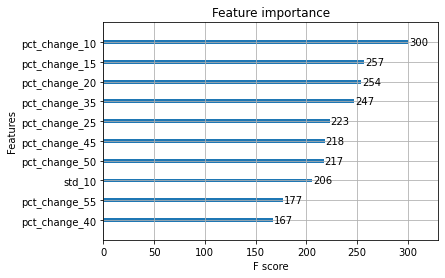

In [36]:
xgboost.plot_importance(model,max_num_features=10)
plt.show()

In [17]:
#predict and classification report

In [37]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.46      0.39      0.43      2016
           1       0.52      0.59      0.55      2233

    accuracy                           0.50      4249
   macro avg       0.49      0.49      0.49      4249
weighted avg       0.49      0.50      0.49      4249



In [19]:
#confusion matrix

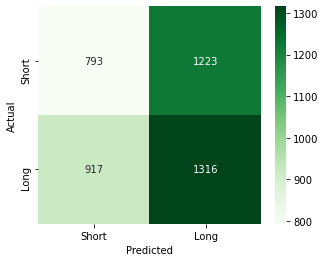

In [38]:
array = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(array, index=['Short', 'Long'], columns=['Short', 'Long'])
    
plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
#Individual stock performance

GC=F


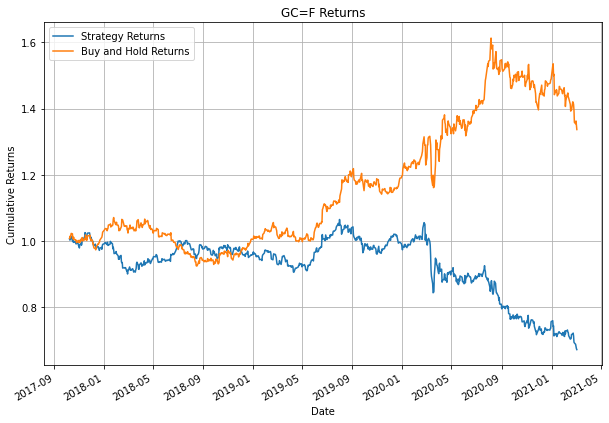

CL=F


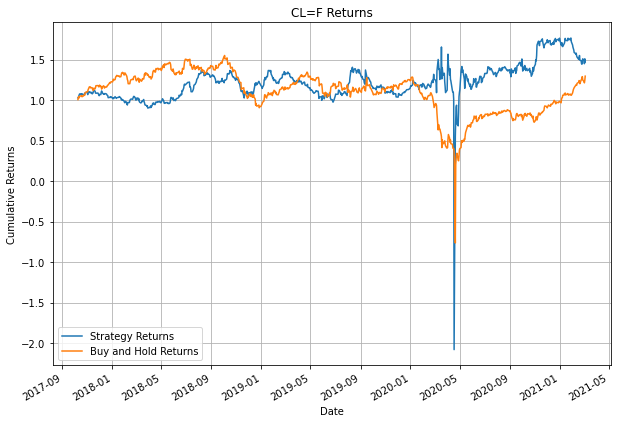

DX=F


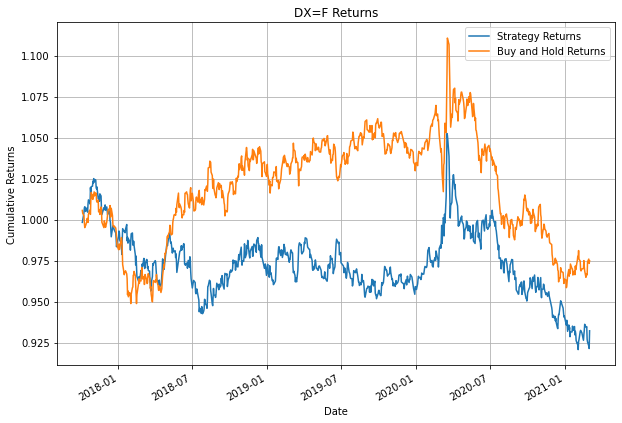

HON


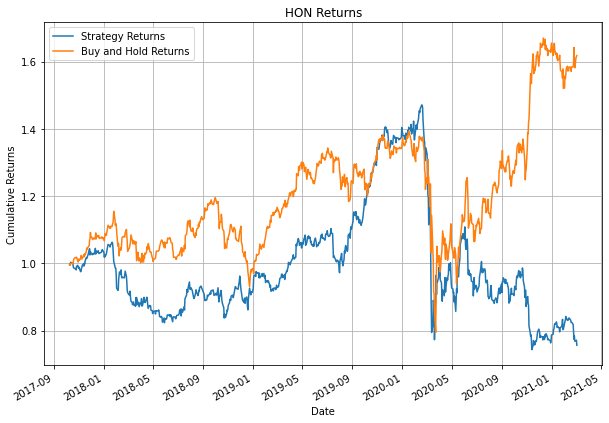

NEM


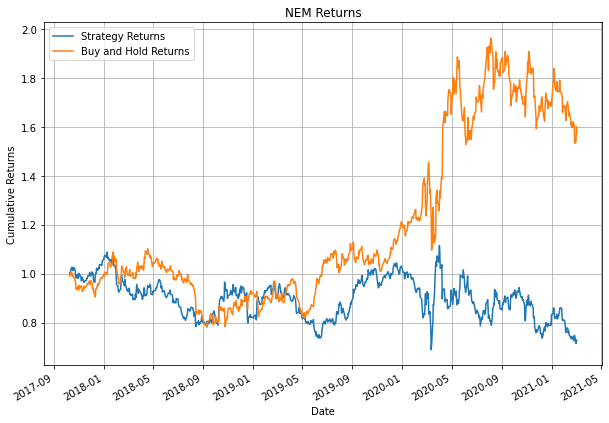

In [39]:
# Create an empty dataframe to store the strategy returns of individual stocks\n",
portfolio = pd.DataFrame(columns=stock_list)
    
# For each stock in the stock list, plot the strategy returns and buy and hold returns\n",
for stock_name in stock_list:

# Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]
    
    #Define the train and test dataset
    train_length = int(len(X)*0.80)
    
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal
    
    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    
    #Plot the stock strategy and buy and hold returns
    print(stock_name)
    
    #Set the figure size
    plt.figure(figsize=(10, 7))
    
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()    
    
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
    plt.grid()
    plt.show()

In [23]:
#Performance of portfolio

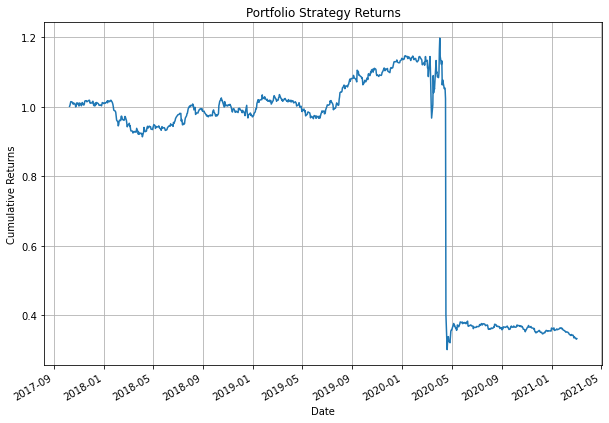

In [40]:
# Drop missing values 
portfolio.dropna(inplace=True) 

# Set the figure size 
plt.figure(figsize=(10, 7)) 
    
# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks 
(portfolio.mean(axis=1)+1).cumprod().plot() 
    
# Set the title and label of the chart 
plt.title('Portfolio Strategy Returns') 
plt.ylabel('Cumulative Returns') 
plt.grid() 
plt.show()

In [25]:
pip install pyfolio

Note: you may need to restart the kernel to use updated packages.


In [41]:
#detailed feedback on the test set

import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))

Start date,2017-10-10
End date,2021-03-03
Total months,40
,Backtest
Annual return,-28.0%
Cumulative returns,-66.7%
Annual volatility,39.4%
Sharpe ratio,-0.52
Calmar ratio,-0.37
Stability,0.50
Max drawdown,-74.9%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'